# Preparatory code

## Imports

In [74]:
from d2l import torch as d2l
import numpy as np
from torch import nn
import torchvision
from torchvision.transforms import v2
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as visionF
import torch.utils
import torch.utils.data
import torcheval
import sklearn
from torch.nn import functional as F
import collections
import seaborn as sns


## Class support functions

In [3]:
def add_to_class(Class):    #@save
    """Register functions as methods in the created class"""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

A defined seed is useful to always have the same split.

In [4]:
generator1 = torch.Generator().manual_seed(42)

# Dataloader

## Generic Dataloader

In [5]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class for data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)
    
    def visualize(self, batch, nrows = 1, ncols = 8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        grid = torchvision.utils.make_grid(X[:8, :, :, :])
        print(labels[:8])
        show(grid)



plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    """The matplotlib function for showing images"""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = visionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## CroppedCells dataloader

On to the implementation of our dataloader.
The structure of `self.train` (or `self.val`) is the following:
* Input images (as an array)
* Tuple (image tensor, label)
* label is an int
* image tensor is (channels, height, width)


In [6]:
def open_image(path):
    return NotImplementedError

In [7]:
def open_image_placeholder(path, transf):
    img = []
    for f in os.listdir(path):
        img.append((transf(torchvision.io.read_image(f"{path}/{f}")), 0))

    
    return img

In [8]:
class CroppedCells(DataModule):
    """The dataset of cropped cells."""
    def __init__(self, fixed_seed = True, transf = v2.Compose([v2.Resize((224, 224)), v2.ToTensor()]), resize = (28, 28), batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        '''
        self.train, self.val = torch.utils.data.random_split(
            dataset = open_image_placeholder('../dataset/TestA/Basophil', transf=transf),
            lengths = [0.75, 0.25],
            generator = generator1 if fixed_seed else None
        )
        
        '''
        self.train = torchvision.datasets.ImageFolder(
            root = '../dataset/TestA/train',
            transform=transf
            )
        self.val = torchvision.datasets.ImageFolder(
            root='../dataset/TestA/val',
            transform=transf
            )
        
    def get_dataloader(self, train=True):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

    def text_labels(self, indices):
        """Return text labels"""
        labels = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
        return [labels[int(i)] for i in indices]

/home/pachy/.cache/pypoetry/virtualenvs/bloodyai-tbuIkQdx-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Dataloader tests

In [9]:
data = CroppedCells()

15
torch.Size([64, 3, 224, 224]) torch.float32 torch.Size([64]) torch.int64
['Neutrophil', 'Neutrophil', 'Lymphocyte', 'Neutrophil', 'Lymphocyte', 'Lymphocyte', 'Neutrophil', 'Neutrophil']


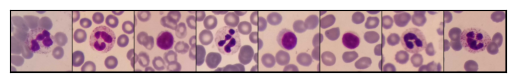

In [10]:
print(len(list(data.val_dataloader())))
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)
data.visualize(next(iter(data.train_dataloader())))

# Models

## Progressboard

In [11]:
class ProgressBoard(d2l.HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        d2l.use_svg_display()
        if self.fig is None:
            self.fig = d2l.plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else d2l.plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

## Generic Model class

In [12]:
class Module(d2l.nn_Module, d2l.HyperParameters):
    """The base class of models.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

## Generic Classifier

In [25]:
import sklearn.metrics


class Classifier(Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""

    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        self.validation_results['correct'].append(batch[-1])
        self.validation_results['predict'].append(Y_hat)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.
    
        Defined in :numref:`sec_classification`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        print(d2l.reduce_mean(compare) if averaged else compare)
        return d2l.reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return visionF.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = d2l.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

    def cross_entropy(self, n_params=5):
        return sklearn.metrics.confusion_matrix(self.validation_results['correct'], self.validation_results['predict'])

## Generic Testing

In [14]:
test_module = Classifier()
test_module.layer_summary

<bound method Classifier.layer_summary of Classifier()>

## ResNet

In [15]:
class Residual(nn.Module):      #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)

        else:
            self.conv3 = None
        self.bn1=nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = nn.functional.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return nn.functional.relu(Y)

In [16]:
class ResNet(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))

        self.net.apply(d2l.init_cnn)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True,strides=2))
            else:
                blk.append(Residual(num_channels))

        return nn.Sequential(*blk)

In [48]:
class ResNet18(ResNet):
    validation_results = {'correct': [], 'predict': []}
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)

### Resnet Testing



In [18]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


/home/pachy/.cache/pypoetry/virtualenvs/bloodyai-tbuIkQdx-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Adding confusion matrix


In [49]:
@d2l.add_to_class(ResNet18)
def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.
    
        Defined in :numref:`sec_classification`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        self.validation_results['correct'].append(d2l.reshape(Y, -1))
        self.validation_results['predict'].append(preds)
        return d2l.reduce_mean(compare) if averaged else compare

In [19]:
'''
input = torch.tensor([0, 2, 1, 3])
target = torch.tensor([0, 1, 2, 3])
torcheval.metrics.functional.multiclass_confusion_matrix(input, target, 4, normalize='all')
'''

"\ninput = torch.tensor([0, 2, 1, 3])\ntarget = torch.tensor([0, 1, 2, 3])\ntorcheval.metrics.functional.multiclass_confusion_matrix(input, target, 4, normalize='all')\n"

# Training

In [20]:
torch.cuda.empty_cache()

## ResNet v0.1

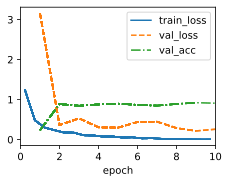

In [50]:
model = ResNet18(lr = 0.02, num_classes=5)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = CroppedCells(batch_size=128)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [72]:
Y_hat = [x.tolist() for x in model.validation_results['predict']]
Y = [x.tolist() for x in model.validation_results['correct']]
Y_hat = sum(Y_hat, [])
Y = sum(Y, [])
len(Y_hat)
len(Y)

9570

<Axes: >

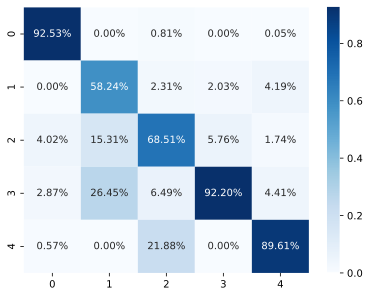

In [81]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import torcheval.metrics
cf_matrix = sklearn.metrics.confusion_matrix(Y, Y_hat)
sns.heatmap(cf_matrix/sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

## Inference testing

In [ ]:
next(iter(data.train_dataloader()))


AttributeError: 'list' object has no attribute 'shape'